In [1]:
import sys
sys.path.insert(0, "/global/u1/p/prakharb/desilike")
import sys
sys.path.insert(0, "/global/u1/p/prakharb/cosmoprimo")
sys.path.insert(0,"/global/u1/p/prakharb/FOLPSpipe/folps")
import desilike, inspect
print(inspect.getfile(desilike))
import cosmoprimo, inspect
print(inspect.getfile(cosmoprimo))
import folps, inspect
print(inspect.getfile(folps))

/global/u1/p/prakharb/desilike/desilike/__init__.py
/global/u1/p/prakharb/cosmoprimo/cosmoprimo/__init__.py
✅ Using NumPy with CPU.
/global/u1/p/prakharb/FOLPSpipe/folps/folps.py


In [2]:
import sys, os, shutil
import time
import emcee
import numpy as np
from schwimmbad import MPIPool

from datetime import datetime

from mike_data_tools import *

In [3]:
derived_params = ['sigma8', 'Omega_m']

k_min=0.02
k_max=0.301
k_max_b0 = 0.14
k_max_b2 = 0.10

isP0, isP2, isP4 =True, True, False
isB000, isB202 = False, False

Vol=1

tracer='LRG'
z_str='z0.800'
z_evaluation=0.8

path_fits='chains/'

now = datetime.now()
tiempo=now.strftime("%m-%d-%Y-%H%M")

name=f"c_FolpsD__{tracer}_z{z_evaluation:.3f}_Pkmax-{k_max:.3f}_B000kmax-{k_max_b0:.3f}_B202kmax-{k_max_b2:.3f}_bsfree"


chains_filename = path_fits+name+".h5"
copy_filename = path_fits+name+".py"
print(chains_filename)
    

# +
k_data_2nd,pkl0_2nd_all,pkl2_2nd_all,a,B000_2nd_all,B202_2nd_all = ExtractDataAbacusSummit(tracer,z_str,
                                                                                           subtract_shot=True)

Pk_0_2nd = np.mean(pkl0_2nd_all,axis = 0)
Pk_2_2nd = np.mean(pkl2_2nd_all,axis = 0)
B000_2nd = np.mean(B000_2nd_all,axis = 0)
B202_2nd = np.mean(B202_2nd_all,axis = 0)


chains/c_FolpsD__LRG_z0.800_Pkmax-0.301_B000kmax-0.140_B202kmax-0.100_bsfree.h5


In [4]:
# Read covariance

k_eff_all,pkl0ezmocks,pkl2ezmocks,pkl4ezmocks,B000ezmocks,B202ezmocks = ExtractDataEZmock(tracer,z_str)
k_cov_all, mean_ezmocks_all, cov_array_all = covariance(k_eff_all,pkl0ezmocks,pkl2ezmocks,pkl4ezmocks,B000ezmocks,B202ezmocks, Nscaling = Vol)



pole_selection=[isP0, isP2, isP4,isB000, isB202]
print(pole_selection)

kmin_pk=0.02; kmax_pk=k_max
kmin_bk=0.02; 
ranges=[[kmin_pk,kmax_pk],[kmin_pk,kmax_pk],[kmin_pk,kmax_pk],[kmin_bk,k_max_b0],[kmin_bk,k_max_b2]]

mask=pole_k_selection(k_cov_all,pole_selection,ranges)
#print(mask.shape)
#print(mask)
k_cov=k_cov_all[mask]

#k_cov.shape
k_points_pk = np.where((kmin_pk < k_data_2nd) & (k_data_2nd < kmax_pk)  & isP0)
k_points_b0 = np.where((kmin_bk < k_data_2nd) & (k_data_2nd < k_max_b0) & isB000)
k_points_b2 = np.where((kmin_bk < k_data_2nd) & (k_data_2nd < k_max_b2) & isB202)

data = np.concatenate((Pk_0_2nd[k_points_pk],Pk_2_2nd[k_points_pk],
                       B000_2nd[k_points_b0],B202_2nd[k_points_b2]))
kr_pk=k_data_2nd[k_points_pk]
kr_b0=k_data_2nd[k_points_b0]
kr_b2=k_data_2nd[k_points_b2]

numberofpk0points=len(Pk_0_2nd[k_points_pk])
numberofbk0points=len(B000_2nd[k_points_b0])
numberofbk2points=len(B202_2nd[k_points_b2])

cov_array=cov_array_all[np.ix_(mask, mask)]
totsim = 2000 #number of sims
n_data = len(data)
Hartlap = (totsim - 1.) / (totsim - n_data - 2.)
Hartlap
cov_arr = cov_array * Hartlap
cov_inv_arr = np.linalg.inv(cov_arr)


[True, True, False, False, False]


In [66]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, LPTVelocileptorsTracerPowerSpectrumMultipoles, KaiserTracerPowerSpectrumMultipoles, DirectPowerSpectrumTemplate,FixedPowerSpectrumTemplate
from desilike.theories.galaxy_clustering.full_shape import  FOLPSv2TracerPowerSpectrumMultipoles,FOLPSAXTracerPowerSpectrumMultipoles, PyBirdTracerPowerSpectrumMultipoles
from desilike.observables import ObservableCovariance
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike import setup_logging

setup_logging()

template = DirectPowerSpectrumTemplate(z=0.8)
theory = FOLPSv2TracerPowerSpectrumMultipoles(template=template, tracer='LRG',freedom='max',kernels='fk',prior_basis='standard',damping='lor',k=kr_pk,ells=[0,2])
observables = TracerPowerSpectrumMultipolesObservable(data=data,covariance=cov_arr,ells=[0,2],k=kr_pk)
likelihood = ObservablesGaussianLikelihood(observables=[observables])
likelihood()

Array(-93628.51492405, dtype=float64)

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/u1/p/prakharb/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
[000029.69] [0/1] 08-04 17:51  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'sn0', 'sn2', 'X_FoG_p'].
[000029.69] [0/1] 08-04 17:51  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'z', 'ells', 'nd'] outputs.
[000031.08] [0/1] 08-04 17:51  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'sn0', 'sn2', 'X_FoG_p'].
[000038.10] [0/1] 08-04 17:51  Differentiation           INFO     Using finite-differentiation for parameter h.
[000039.28] [0/1] 08-04 17:51  Differentiation           INFO     Using finite-differentiation for parameter omega_cdm.
[000040.73] [0/1] 08-04 17:51  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[000042.17] [0/1] 08-04 17:51  Differentiation       

[<Figure size 600x600 with 2 Axes>]

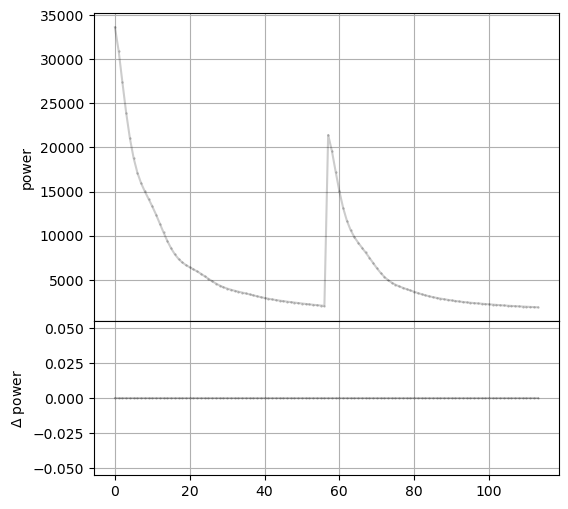

In [67]:
from desilike.emulators import Emulator
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine
emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.plot(name='power')
# emulator= Emulator.load('../_tests/folpsv2_emulator.npy')

In [64]:
import os
base_dir = '_tests'
folps_emulator_fn = os.path.join(base_dir, 'folpsv2_emulator_LRG.npy')
emulator.save(folps_emulator_fn)

[000151.26] [0/1] 08-04 17:46  Emulator                  INFO     Saving _tests/folpsv2_emulator_LRG.npy.
[000151.27] [0/1] 08-04 17:46  BaseConfig                INFO     Saving _tests/folpsv2_emulator_LRG.yaml.


In [ ]:


from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observables.init.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_direct_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1})

[000147.91] [0/1] 08-04 17:53  ZeusSampler               INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'sn0', 'sn2', 'X_FoG_p'].


[000148.68] [0/1] 08-04 17:53  ZeusSampler               INFO     Successfully vmap input likelihood.
[000149.08] [0/1] 08-04 17:53  ZeusSampler               INFO     Successfully jit input likelihood.
[000149.59] [0/1] 08-04 17:53  root                      INFO     Initialising ensemble of 32 walkers...
[000249.31] [0/1] 08-04 17:55  Chain                     INFO     Saving _tests/chain_fs_direct_0.npy.
[000249.32] [0/1] 08-04 17:55  ZeusSampler               INFO     Diagnostics:
[000249.39] [0/1] 08-04 17:55  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.0877; < 0.1.
[000249.52] [0/1] 08-04 17:55  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.00452.
[000250.17] [0/1] 08-04 17:55  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.106.
[000250.27] [0/1] 08-04 17:55  Diagnostics               INFO     - max Geweke is 0.0862.
[000250.28] [0/1] 08-04 17:55  Diagnostics               INFO     - Geweke p-value 

In [52]:
theory=emulator.to_calculator()

In [69]:
a,b=theory()

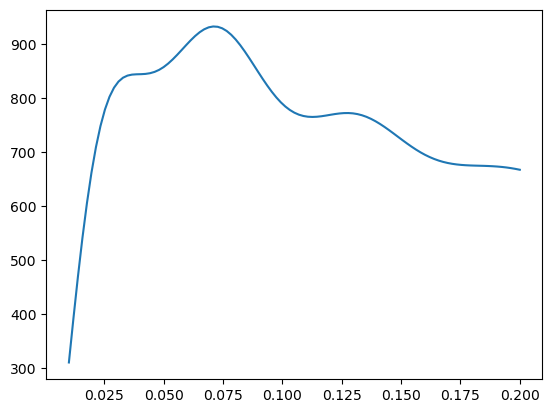

In [59]:
import matplotlib.pyplot as plt
k=theory.k
plt.plot(k,a*k,label='P0')

In [58]:
b.shape

(101,)

In [60]:
k

array([0.01  , 0.0119, 0.0138, 0.0157, 0.0176, 0.0195, 0.0214, 0.0233,
       0.0252, 0.0271, 0.029 , 0.0309, 0.0328, 0.0347, 0.0366, 0.0385,
       0.0404, 0.0423, 0.0442, 0.0461, 0.048 , 0.0499, 0.0518, 0.0537,
       0.0556, 0.0575, 0.0594, 0.0613, 0.0632, 0.0651, 0.067 , 0.0689,
       0.0708, 0.0727, 0.0746, 0.0765, 0.0784, 0.0803, 0.0822, 0.0841,
       0.086 , 0.0879, 0.0898, 0.0917, 0.0936, 0.0955, 0.0974, 0.0993,
       0.1012, 0.1031, 0.105 , 0.1069, 0.1088, 0.1107, 0.1126, 0.1145,
       0.1164, 0.1183, 0.1202, 0.1221, 0.124 , 0.1259, 0.1278, 0.1297,
       0.1316, 0.1335, 0.1354, 0.1373, 0.1392, 0.1411, 0.143 , 0.1449,
       0.1468, 0.1487, 0.1506, 0.1525, 0.1544, 0.1563, 0.1582, 0.1601,
       0.162 , 0.1639, 0.1658, 0.1677, 0.1696, 0.1715, 0.1734, 0.1753,
       0.1772, 0.1791, 0.181 , 0.1829, 0.1848, 0.1867, 0.1886, 0.1905,
       0.1924, 0.1943, 0.1962, 0.1981, 0.2   ])

# Chain Plotting

In [ ]:
%matplotlib inline

from desilike.samples import Chain
from desilike import setup_logging
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
setup_logging()

#funtion to load numpy chains
def load_chain(fi, burnin=0.5):
    from desilike.samples import Chain
    chains = [Chain.load(ff).remove_burnin(burnin) for ff in fi]
    chain = chains[0].concatenate(chains)
    print(f'chain: {chain}')
    return chain

In [ ]:
default_path = Path('/global/cfs/cdirs/desi//survey/catalogs/DA2/analysis/loa-v1/LSScats/v1.1/BAO/blinded/desipipe/fits_2pt/fits_power_dampedbao_bao-qisoqap_pcs/recon_IFFT_recsym_sm30/')
# P0 +P2 chains
base_path= f'{default_path}/chain_QSO_GCcomb_z0.8-2.1_default_FKP_cov-thecov_sigmas-2.0-2.0_sigmapar-6.0-2.0_sigmaper-3.0-1.0_lim_0-0.02-0.30_2-0.02-0.30'   
# P0+P2+P4 chains
base_path2= f'{default_path}/chain_QSO_GCcomb_z0.8-2.1_default_FKP_cov-thecov_sigmas-2.0-2.0_sigmapar-6.0-2.0_sigmaper-3.0-1.0_lim_0-0.02-0.30_2-0.02-0.30_4-0.02-0.30'
#base_path_corr = f'{default_corr_path}/chain_LRG_GCcomb_z0.8-1.1_default_FKP_cov-rascalc_sigmas-2.0-2.0_sigmapar-11.25-2.0_sigmaper-5.0-1.0_lim_0-60-150_2-60-150'
chain_paths = []
chain_paths2=[]

for i in range(8):
    chain_paths.append(f'{base_path}_{i}.npy')
    chain_paths2.append(f'{base_path2}_{i}.npy')

In [ ]:
chain = load_chain(chain_paths)[::10]
chain2 = load_chain(chain_paths2)[::10]

In [ ]:
from desilike.samples import plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'  #You can use 'monospace', 'Times New Roman', etc.
plt.rcParams['legend.fontsize'] = 50
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# import matplotlib.pyplot as plt

plotting.plot_triangle([chain,chain2], params=['qiso','qap','qpar', 'qper'],filled=[True,False],lw=[1,50],contour_colors=['orangered','black'],contour_ls=['-','--'],contour_lws=2,line_args=[{'color': 'orangered','ls':'-'},{'color': 'black','ls':'--','lw':2}],legend_labels=['$P_0+P_2 $','$P_0+P_2+P_4$'])
#plotting.plot_triangle([chain,chain2], params=['qiso','qap','qpar', 'qper'],filled=[True,False],show=True)
#fig.settings.legend_fontsize = 30
#fig.settings.line_labels =False

#fig.add_legend(legend_labels=['$P_0+P_2 $','$P_0+P_2+P_4$'],bbox_to_anchor=(0.1,4.2),fontsize=20,frameon=True)
#fig.export('Hexadecapole.png')

#plotting.plot_triangle([chain], params=['qpar', 'qper'],labels=['$P_0+P_2+P_4$'],filled=True,smooth_scale_2d=0.1)
#plt.title('LRG 0.8-1.1')
#plotting.save_fig('P4.png')
#fig.add_text('LRG in 0.8<z<1.1')